# Learning  discrete Lagrangian for Kepler

This notebook studies learning the discrete lagrangian the cart pendulum system in a self-contained and continuous manner using the various modules implemented in the project repo.

In [1]:
# General imports
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jaxopt
import numpy as np
from jax.experimental.ode import odeint
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

from jax.config import config
config.update("jax_enable_x64", True)

# import our modules
from model_new_loss import NNLearner
from dataset_generator import TrajectoryDataset

## System configuration

In [2]:
# Set system
from systems.system_Kepler_cartes import Kepler_lagrangian_cartes, solve_lagrangian_autograd, hamiltonian_Kepler_cart,f_autograd
from jax import jit
target = 'tripple'     
learning = 'Ld'         

N = 50
N_simul_after_learning = 200 #must be larger than N
num_epochs = 100000

stepsize = 0.1
test_every_choice = 10

weight_loss_choice = 1
weight_cond_choice = 0
weight_degeneracy = 1


dof = 2
system_lagrangian = Kepler_lagrangian_cartes
x0 = np.array([1., 0., 0., .6], dtype=np.float64) 
x0_test = np.array([1.1, -0.01, 0., 0.6], dtype=np.float64)  
q0_train, v0_train = jnp.split(x0, 2)
p0_train = jax.grad(system_lagrangian,argnums = 1)(q0_train, v0_train)

q0_test, v0_test = jnp.split(x0_test, 2)
p0_test = jax.grad(system_lagrangian,argnums = 1)(q0_test, v0_test)

base_point = (0*q0_train, 0*q0_train, jnp.ones((dof))*10) # (q0, q1, p0)
base_point_tripple = base_point
print(base_point)


(DeviceArray([0., 0.], dtype=float64), DeviceArray([0., 0.], dtype=float64), DeviceArray([10., 10.], dtype=float64))


### Generate trajectories using solvers to be used for dataset generation later

In [3]:
from SVI_integrators import SVI_solver_TQs
def discrete_lagrangian_orig(qk, qk_1, h):
    return h*system_lagrangian((qk+qk_1)/2,(qk_1-qk)/h)


from utils import f2c_trajectory

proportion_f2c = int(stepsize/0.001)
train_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)
test_trajectory = f2c_trajectory(proportion_f2c, stepsize, N, SVI_solver_TQs, discrete_lagrangian_orig, q0_test, p0_test)



100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.44it/s]

The train trajectory has shape (51, 4) with dtype float64
The test trajectory has shape (51, 4) with dtype float64


Text(0.5, 1.0, 'comparing how different the test and train trajs are')

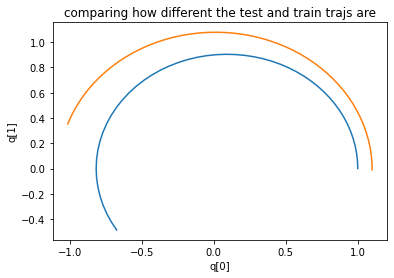

In [4]:
plt.plot(train_trajectory[:,0], train_trajectory[:,1], label="train traj")
plt.plot(test_trajectory[:,0], test_trajectory[:,1], label="test traj")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('comparing how different the test and train trajs are')

## Dataset generation from trajectories

In other words map the analytically generated trajectory into a dataset of (input, target) observation tuples to be used for training our model. Note there are different (input, target) observations generated based on the `mode` parameter of the `TrajectoryDataset` instantiation.

The `TrajectoryDataset` extends `torch.utils.data.Dataset` and hence has the same behaviour (API) with some additional attributes. Supports index based subscript access to the dataset. 

In [7]:
train_dataset = TrajectoryDataset(input_trajectory=train_trajectory, 
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)
test_dataset = TrajectoryDataset(input_trajectory=test_trajectory, 
    mode="tripple_Ld", lagrangian=system_lagrangian, np_mode=True)

len(train_dataset)

49

## Instantiating and fitting a neural network model

In the cell below we specify the `NNLearner` which involves specifying: the functional model (architecture of the network), the optimiser (and any hyperparameters it will have, the train and test dataset, the loss function to be used, and any additional hyperparameters.

To specify the functional model modify the arguments of the `stax.serial` function below, which will be passed into the `NNLearner` via the `stax` argument.

Specification of the optimiser is done via two arguments to the `NNLearner`: the `optimizer` str argument which expects the name of the optimiser to be used (currently only "adam" and "sgd"), the other argument is the `optimizer_parameters` which are any additional hyperparameters passed into the internal `optimisers.<adam/sgd>` instantiation. 

In [8]:
from jax.example_libraries import stax
from jax.example_libraries import optimizers



stax_nn = stax.serial(
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(128),
        stax.Softplus,
        stax.Dense(1),
        )
optimizer_parameters = lambda t: jnp.select([t < 1000, t > 2000, t > 3000, t > 4000, t > 5000, t > 8000, t > 10000, t > 12000, t > 18000, t > 25000], [3e-3, 3e-4, 3e-5, 3e-6, 3e-7, 3e-7, 3e-7, 3e-8, 3e-8, 3e-8])

model = NNLearner(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    loss="tripple_Ld",
    h=stepsize,
    stax=stax_nn,
    dof=dof,  
    input_shape=2 * dof,
    weight_loss=weight_loss_choice, 
    weight_cond=weight_cond_choice,
    weight_degeneracy=weight_degeneracy,
    base_point_tripple=base_point_tripple,
    optimizer="adam",
    optimizer_parameters = optimizer_parameters
)

params, train_losses_record, test_losses_record = model.fit2( 
    num_epochs=num_epochs, test_every=test_every_choice
)


## Learning the lagrangian


Epochs progress: 100%|██████████████████| 100000/100000 [29:17<00:00, 56.90it/s]


### Plot the training and test loss over the epochs (x ticks according to recorded steps)

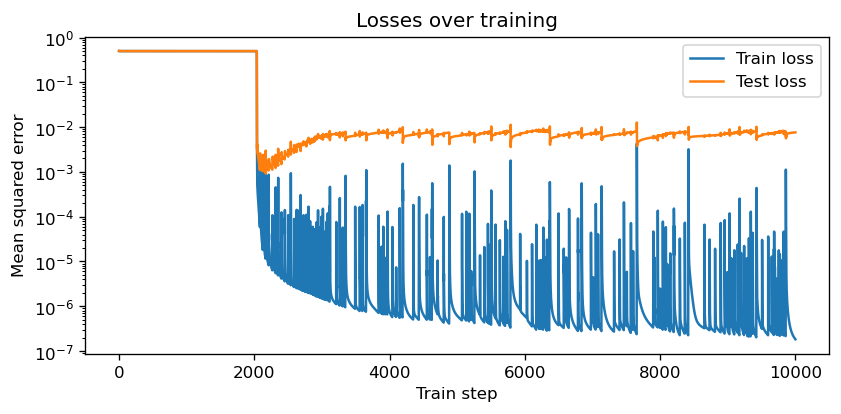

In [9]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses_record, label='Train loss')
plt.plot(test_losses_record, label='Test loss')
plt.yscale('log')

plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

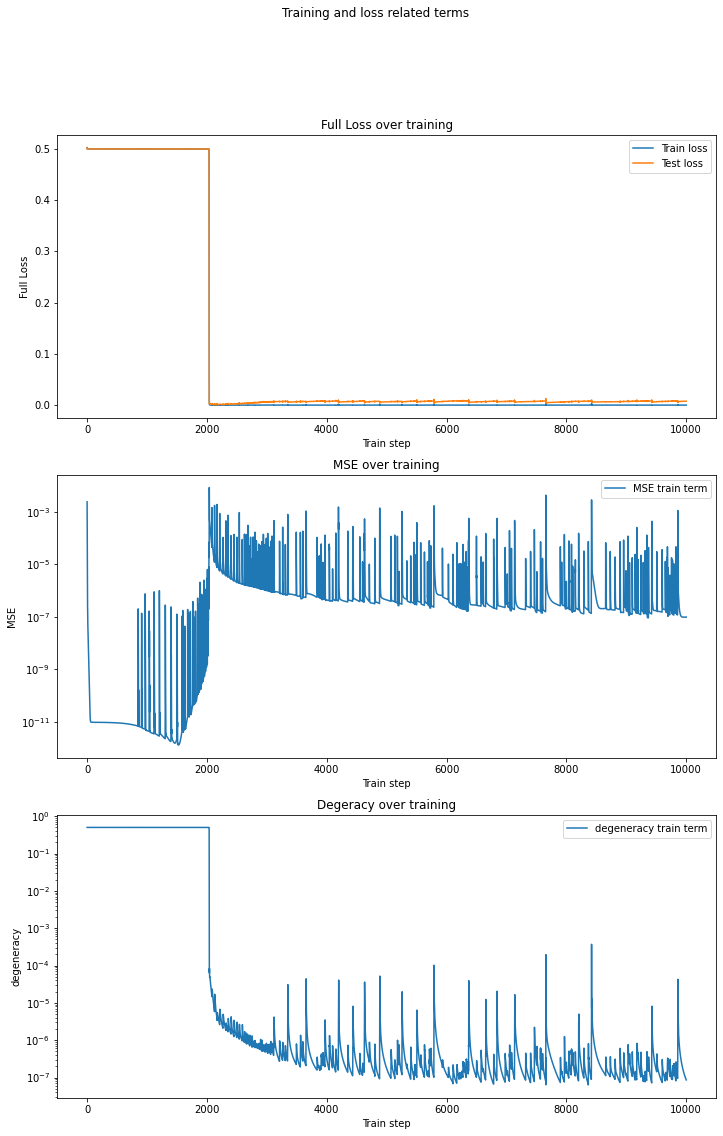

In [64]:
#####
##### Plotting training related loss terms
#####
cm = 1/2.54
fig, axs = plt.subplots(3, figsize=(30*cm, (3*15)*cm))
fig.suptitle('Training and loss related terms')

# Plotting loss curve
# plt.figure(figsize=(8, 3.5), dpi=120)
axs[0].plot(train_losses_record, label='Train loss')
axs[0].plot(test_losses_record, label='Test loss')
# axs[0].set_yscale('log')
axs[0].set_title('Full Loss over training')
axs[0].set(xlabel = "Train step", ylabel = "Full Loss")
axs[0].legend()

# Plot the MSE component of the loss curve
axs[1].plot(model.mse_losses, label='MSE train term')
axs[1].set_title('MSE over training')
axs[1].set_yscale('log')
axs[1].set(xlabel = "Train step", ylabel = "MSE")
axs[1].legend()                                  

# Plot the degeneracy component of the loss curve
axs[2].plot(model.degeneracy_values, label='degeneracy train term')
axs[2].set_title('Degeracy over training')
axs[2].set_yscale('log')
axs[2].set(xlabel = "Train step", ylabel = "degeneracy")
axs[2].legend()    

In [11]:
def Ldk(q_k, q_k1):
    return  model.learned_lagrangian(params) (q_k,q_k1)
def D2Ld1k(q_1k, q_k): 
    return jax.grad(Ldk, argnums=1)(q_1k, q_k)
def D1Ldk(q_k, q_k1):  
    return jax.grad(Ldk, argnums=0)(q_k, q_k1)

result = np.zeros((dof,10-1))
mse  = np.zeros((1,10-1))

for k in range(0,10-1):

    q_1k = train_trajectory[k,0:dof]

    q_k = train_trajectory[k+1,0:dof]

    q_k1 = train_trajectory[k+2,0:dof]

    def D2_D1Ldk(q_k, q_k1):
        return jax.jacrev(D1Ldk, argnums=1)(q_k, q_k1)

    print(np.linalg.eigvals(D2_D1Ldk(q_k, q_k1)))

    result[:,k] = D2Ld1k(q_1k, q_k) + D1Ldk(q_k, q_k1)
    print(result[:,k])

[40.02842807 47.28248547]
[ 0.00045999 -0.0003182 ]
[40.00547547 47.23186953]
[ 2.66031893e-04 -5.65136184e-05]
[39.97788321 47.16924804]
[9.99459555e-05 1.12935813e-04]
[39.94595181 47.09381984]
[-3.59369256e-05  2.03646539e-04]
[39.91003013 47.00484967]
[-0.00014032  0.00023024]
[39.87050993 46.90168806]
[-0.00021301  0.0002078 ]
[39.82781928 46.78378939]
[-0.00025498  0.00015119]
[39.78241469 46.65072806]
[-2.68301082e-04  7.45169144e-05]
[39.73477205 46.50221295]
[-2.56098467e-04 -9.47314921e-06]


# Simulating (trying to recreate) the train trajectory using the learnt Lagrangian and predicting future behaviour

MAKING THE DISCRETE APPROX OF THE LEARNT Ld

In [12]:
def discrete_lagrangian_based_on_NN(qk,qk_1,h): ## here because we have learnt Ld we do not need to do much
    return model.learned_lagrangian(params)(qk,qk_1)


First we try to recreate the train trajectory which is N steps long

100%|███████████████████████████████████████████| 49/49 [01:18<00:00,  1.60s/it]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory')

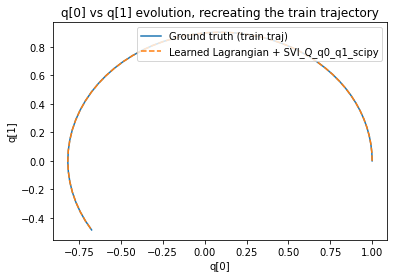

In [13]:
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]

q_model_SVI_Q_q0_q1_scipy, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N,"hybr")
q_model_SVI_Q_q0_q1_scipy2 =q_model_SVI_Q_q0_q1_scipy.T

#plot
plt.plot(train_trajectory[:,0],train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],q_model_SVI_Q_q0_q1_scipy2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory')

Text(0.5, 1.0, 'q[0]  evolution, recreating the train trajectory')

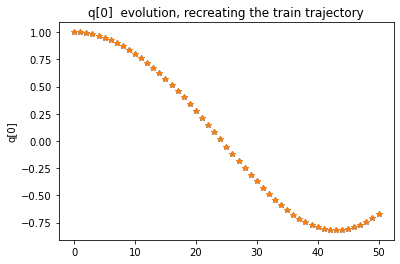

In [14]:
plt.plot(train_trajectory[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')
plt.title('q[0]  evolution, recreating the train trajectory')

Text(0.5, 1.0, ' q[1] evolution, recreating the train trajectory')

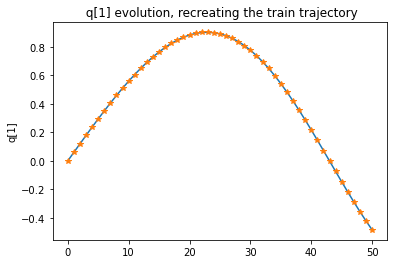

In [15]:
plt.plot(train_trajectory[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title(' q[1] evolution, recreating the train trajectory')

Nex we try to recreate the train trajectory and also predict for additional steps with a total stels of N_simul_after_learning 

100%|█████████████████████████████████████████| 199/199 [05:22<00:00,  1.62s/it]


Text(0.5, 1.0, 'q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

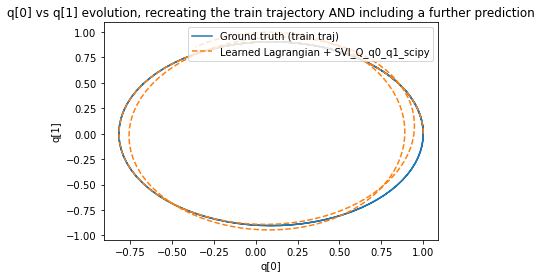

In [16]:
### SVI Q INTEGRATOR, TAKING q0 and q1 AS INITIAL DATA AND SCIPY ROOT FINDERS
from SVI_integrators import  SVI_solver_Q_noinitstep_scipyroot
q0=train_trajectory[0,0:dof]
q1 = train_trajectory[1,0:dof]
N_simul_after_learning = 200
train_trajectory_extra = f2c_trajectory(proportion_f2c, stepsize, N_simul_after_learning, SVI_solver_TQs, discrete_lagrangian_orig, q0_train, p0_train)

q_model_SVI_Q_q0_q1_scipy_extra, times_SVI_Q_q0_q1_scipy = SVI_solver_Q_noinitstep_scipyroot(discrete_lagrangian_based_on_NN, stepsize, q0, q1, N_simul_after_learning,"hybr")
q_model_SVI_Q_q0_q1_scipy_extra2 =q_model_SVI_Q_q0_q1_scipy_extra.T

#plot
plt.plot(train_trajectory_extra[:,0],train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],q_model_SVI_Q_q0_q1_scipy_extra2[:,1],'--', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.legend(loc="upper right")
plt.xlabel('q[0]')
plt.ylabel('q[1]')
plt.title('q[0] vs q[1] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[0] evolution, recreating the train trajectory AND including a further prediction')

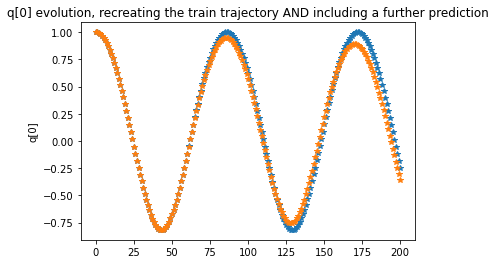

In [17]:

plt.plot(train_trajectory_extra[:,0], '*',label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,0],'*', label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[0]')

plt.title('q[0] evolution, recreating the train trajectory AND including a further prediction')

Text(0.5, 1.0, 'q[1] evolution, recreating the train trajectory AND including a further prediction')

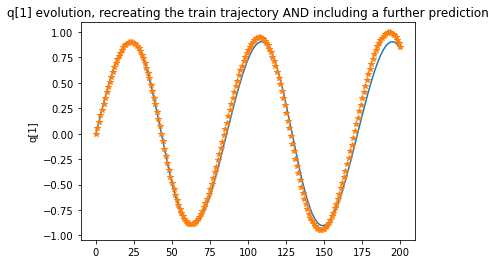

In [18]:
plt.plot(train_trajectory_extra[:,1], label="Ground truth (train traj)")
plt.plot(q_model_SVI_Q_q0_q1_scipy_extra2[:,1], '*',label="Learned Lagrangian + SVI_Q_q0_q1_scipy")
plt.ylabel('q[1]')
plt.title('q[1] evolution, recreating the train trajectory AND including a further prediction')

In this example the symmetry I = p^T Mq with M = [0, 1/sqrt(2);-1/sqrt(2),0]. 

In the folowing tests when we refer to tajc computed from the learnt LD we use our recreation of the train trajectory and in the second part it plus an extended prediction on which we have not trained previously.


In [47]:
from jax import jit,grad
from SVI_funcs import SVI_funcs

def pm_calc_orig(q,v):
    return  jax.grad(system_lagrangian ,argnums = 1)(q,v)  
pm_calc_orig_jitted = jit(pm_calc_orig)

def learned_continuous_Lagrangian(q,qdot): 
    q0 = q-stepsize/2*qdot
    q1 = q+stepsize/2*qdot    
    return model.learned_lagrangian(params)(q0,q1)/stepsize

L_backward  = lambda q,qdot: L_BEA2d(learned_continuous_Lagrangian,stepsize)(jnp.hstack([q,qdot]))


M_orig = np.zeros((2,2))
M_orig[0,1] = 1/np.sqrt(2)
M_orig[1,0] = -1/np.sqrt(2)
def symmetry_func_orig(q,p):
    return jnp.dot(p,M_orig@q)

def getting_symmetry_conservation_test(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start,naming_info):
    #v0_start = v0_train
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T

    p_Lorig_qlearnt_vlearntCD = np.zeros((dof,number_steps))
    p_Lorig_qlearnt_vlearntCD[:,0] = pm_calc_orig_jitted(traj_from_learnt_Ld[:,0],v0_start)  
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        p_Lorig_qlearnt_vlearntCD[:,k] = pm_calc_orig_jitted(qk,vk)

    I_Lorig_qlearnt_vlearntCD = np.zeros((number_steps))
    for k in range(0, number_steps): 
        I_Lorig_qlearnt_vlearntCD[k] = symmetry_func_orig( traj_from_learnt_Ld[:,k],p_Lorig_qlearnt_vlearntCD[:,k])

    

    return I_Lorig_qlearnt_vlearntCD




Testing first with the recreated traintrajectory

In [48]:
I_Lorig_qlearnt_vlearntCD = getting_symmetry_conservation_test(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train,'based on recreating the train trajectory')


Text(0.5, 1.0, 'I ERROR comparison recreaing the train trajectory')

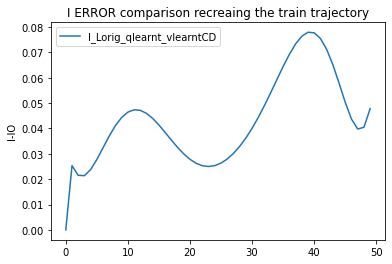

In [49]:
plt.plot(I_Lorig_qlearnt_vlearntCD-I_Lorig_qlearnt_vlearntCD[0]*np.ones((N)), label="I_Lorig_qlearnt_vlearntCD")

plt.legend(loc="upper left")
plt.ylabel('I-IO')
plt.title('I ERROR comparison recreaing the train trajectory')


    Now with extra predctions

In [50]:
I_Lorig_qlearnt_vlearntCD_extra= getting_symmetry_conservation_test(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train,'based on recreating the train trajectory and predicting its extension')


Text(0.5, 1.0, 'I ERROR comparison recreaing and predicting the train trajectory')

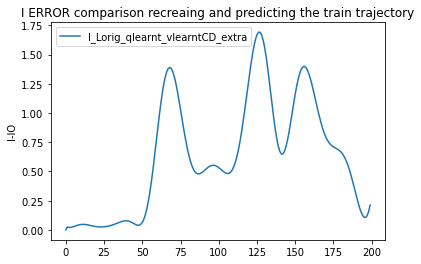

In [53]:
plt.plot(I_Lorig_qlearnt_vlearntCD_extra-I_Lorig_qlearnt_vlearntCD_extra[0]*np.ones((N_simul_after_learning)), label="I_Lorig_qlearnt_vlearntCD_extra")

plt.legend(loc="upper left")
plt.ylabel('I-IO')
plt.title('I ERROR comparison recreaing and predicting the train trajectory')



Hamiltonian plots in time (including backward error)

In [54]:

from Hamiltonian_Identification import *
def learned_continuous_Lagrangian(q,qdot): 
    q0 = q-stepsize/2*qdot
    q1 = q+stepsize/2*qdot    
    return model.learned_lagrangian(params)(q0,q1)/stepsize
    
H_ref = Hamiltonian_from_L(system_lagrangian)
H_learnt    = Hamiltonian_from_L(learned_continuous_Lagrangian)
HBEA  = Hamiltonian_from_L(lambda q,qdot: L_BEA2d(learned_continuous_Lagrangian,stepsize)(jnp.hstack([q,qdot])))

H_Ref = jit(H_ref)
H_learnt = jit(H_learnt)
HBEA = jit(HBEA)

In [55]:

def H_simulation_tests(q_ground_truth,q_predicted_using_learntLd,number_steps,v0_start):
    orig_traj = q_ground_truth[:,0:dof].T
    traj_from_learnt_Ld = q_predicted_using_learntLd[:,0:dof].T


    Horig_qorig_vorigCD = np.zeros((number_steps))
    Horig_qorig_vorigCD[0] = H_ref( orig_traj[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-orig_traj[:,k-1]+orig_traj[:,k+1])/2/stepsize
        qk = orig_traj[:,k]
        Horig_qorig_vorigCD[k] = H_ref( qk, vk)
        
    Hbea_qlearnt_vlearntCD = np.zeros((number_steps))
    Hbea_qlearnt_vlearntCD[0] = HBEA( traj_from_learnt_Ld[:,0], v0_start)
    for k in range(1, number_steps): 
        vk =  (-traj_from_learnt_Ld[:,k-1]+traj_from_learnt_Ld[:,k+1])/2/stepsize
        qk = traj_from_learnt_Ld[:,k]
        Hbea_qlearnt_vlearntCD[k] = HBEA( qk, vk)

    return Horig_qorig_vorigCD, Hbea_qlearnt_vlearntCD




In [58]:
 Horig_qorig_vorigCD,Hbea_qlearnt_vlearntCD = H_simulation_tests(train_trajectory,q_model_SVI_Q_q0_q1_scipy2,N,v0_train)

print('Horig',Horig_qorig_vorigCD[0],Horig_qorig_vorigCD[1])
print('Hbea',Hbea_qlearnt_vlearntCD[0],Hbea_qlearnt_vlearntCD[1])



Horig -22.038000000000004 -22.06203761307301
Hbea -115.7794831867182 -115.77820038162491


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory ')

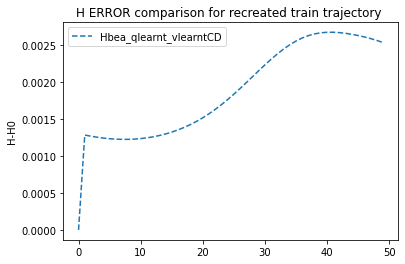

In [59]:
plt.plot(Hbea_qlearnt_vlearntCD - Hbea_qlearnt_vlearntCD[0]*jnp.ones((N)), '--', label="Hbea_qlearnt_vlearntCD")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory ')

Now with some prediction

In [60]:
Horig_qorig_vorigCD_extra,Hbea_qlearnt_vlearntCD_extra = H_simulation_tests(train_trajectory_extra,q_model_SVI_Q_q0_q1_scipy_extra2,N_simul_after_learning,v0_train)

print('Horig',Horig_qorig_vorigCD_extra[0],Horig_qorig_vorigCD_extra[1])
print('Hbea',Hbea_qlearnt_vlearntCD_extra[0],Hbea_qlearnt_vlearntCD_extra[1])



Horig -22.038000000000004 -22.06203761307301
Hbea -115.7794831867182 -115.77820038162491


Text(0.5, 1.0, 'H ERROR comparison for recreated train trajectory AND a prediction')

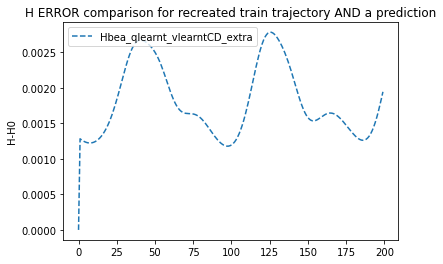

In [62]:
plt.plot(Hbea_qlearnt_vlearntCD_extra - Hbea_qlearnt_vlearntCD_extra[0]*jnp.ones((N_simul_after_learning)), '--', label="Hbea_qlearnt_vlearntCD_extra")

plt.legend(loc="upper left")
plt.ylabel('H-H0')
plt.title('H ERROR comparison for recreated train trajectory AND a prediction')

In [66]:

import os
import pickle
from pathlib import Path

approach = "DLNN" # LNN, DLNN, or SymDLNN
group = "C" # A, B, C, D, or E
path_to_results = os.path.join("results_final", group, approach)
Path(path_to_results).mkdir(parents=True, exist_ok=True)

pkl_filename = os.path.join(path_to_results, "results_dict.pkl")

# DLNN version for kepler
dict_to_save = {
    "train_trajectory": train_trajectory,
    "test_trajectory": test_trajectory,
    "train_losses_record": train_losses_record,
    "test_losses_record": test_losses_record,
    "q_model_SVI_Q_q0_q1_scipy": q_model_SVI_Q_q0_q1_scipy,
    "q_model_SVI_Q_q0_q1_scipy2": q_model_SVI_Q_q0_q1_scipy2,
    "train_trajectory_extra": train_trajectory_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra": q_model_SVI_Q_q0_q1_scipy_extra,
    "q_model_SVI_Q_q0_q1_scipy_extra2": q_model_SVI_Q_q0_q1_scipy_extra2,

    "I_Lorig_qorig_vorigCD_extra": I_Lorig_qorig_vorigCD_extra,
    "I_Lorig_qlearnt_vlearntCD_extra": I_Lorig_qlearnt_vlearntCD_extra,

    "Horig_qorig_vorigCD_extra": Horig_qorig_vorigCD_extra, 
    "Hbea_qlearnt_vlearntCD_extra": Hbea_qlearnt_vlearntCD_extra,
    
    "I_Ldinvmod_qlearnt_vlearntCD": I_Ldinvmod_qlearnt_vlearntCD,
    "I_Ldinvmod_qlearnt_vlearntCD_extra": I_Ldinvmod_qlearnt_vlearntCD_extra
}

with open(pkl_filename, "wb") as fh:
    pickle.dump(dict_to_save, fh)
